# SETTINGS

In [1]:
############ LIBRARIES

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')
%matplotlib inline

import os
import time
import random
import multiprocessing
import pickle

import scipy.stats

import gc
gc.enable()

import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.decomposition import PCA, FastICA, FactorAnalysis
from sklearn.metrics import log_loss, roc_auc_score, confusion_matrix
from sklearn.neighbors import NearestNeighbors

In [2]:
############ HELPER FUNCTIONS

import functions
import importlib
importlib.reload(functions)
from functions import *

In [3]:
############ RANDOMNESS

# seed function
def seed_everything(seed = 23):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    
# set seed
seed = 23
seed_everything(seed)

# DATA PREPARATION

In [4]:
# import CSV
df = pd.read_pickle('../input/data_v9.pkl')
print(df.shape)

(1097231, 511)


In [5]:
# target variable
target = 'isFraud'

In [6]:
# partitioning
train = df[df[target].isnull() == False]
test  = df[df[target].isnull() == True]
print(train.shape)
print(test.shape)
del df

(590540, 511)
(506691, 511)


In [7]:
# extract target
y = train[target]
del train[target], test[target]

# MODELING

### PARAMETERS

In [8]:
############ FEAUTERS

# drop bad features
excluded_feats = ['TransactionID', 'TransactionDT',
                  'bank_type',
                  'uid1', 'uid2', 'uid3', 'uid4', 'uid5', 
                  'DT', 'DT_D', 'DT_W', 'DT_M', 'DT_hour', 
                  'DT_day_week', 'DT_day_month', 
                  'DT_D_total', 'DT_W_total', 'DT_M_total']
features = [f for f in train.columns if f not in excluded_feats]
print(train[features].shape)

(590540, 504)


In [9]:
############ PARAMETERS

# cores
cores = 24

# cross-validation
num_folds = 6
shuffle   = True

# number of trees
max_rounds = 100
stopping   = 200
verbose    = 250

# LGB parameters
lgb_params = {
    'boosting_type':     'gbdt',
    'objective':         'binary',
    'metric':            'auc',
    'bagging_fraction':  0.9,
    'feature_fraction':  0.9,
    'lambda_l1':         0.1,
    'lambda_l2':         0.1,
    'min_split_gain':    0,
    'min_child_weight':  0.1,
    'min_child_samples': 20,
    'silent':            True,
    'verbosity':         -1,
    'learning_rate':     0.01,
    'max_depth':         7,
    'num_leaves':        256,
    'scale_pos_weight':  1,
    'n_estimators':      max_rounds,
    'nthread' :          cores,
    'random_state':      seed,
}


lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':cores,
                    'learning_rate':0.005,
                    'num_leaves': 2**8,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.5,
                    'subsample_freq':1,
                    'subsample':0.8,
                    'n_estimators':max_rounds,
                    'max_bin':255,
                    'verbose':-1,
                    'seed': seed,
                } 


# data partitinoing
#folds = StratifiedKFold(n_splits = num_folds, random_state = seed, shuffle = shuffle)
folds = GroupKFold(n_splits = num_folds)

# SMOTE settings
#from imblearn.over_sampling import SMOTE
#sm = SMOTE(random_state = seed, n_jobs = cores, sampling_strategy = 0.05)

In [10]:
############ PLACEHOLDERS

# placeholders
clfs = []
importances = pd.DataFrame()

# predictions
preds_test   = np.zeros(test.shape[0])
preds_oof    = np.zeros(train.shape[0])

### CROSS-VALIDATION

In [11]:
############ CROSS-VALIDATION LOOP
cv_start  = time.time()
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train, y, groups = train['DT_M'])):
    
    # data partitioning
    trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]
    test_x       = test[features]
    
    ## augment training data with SMOTE
    #trn_x[trn_x.columns]  = trn_x[trn_x.columns].apply(pd.to_numeric,   errors = 'coerce')
    #val_x[val_x.columns]  = val_x[val_x.columns].apply(pd.to_numeric,   errors = 'coerce')
    #test_x[val_x.columns] = test_x[test_x.columns].apply(pd.to_numeric, errors = 'coerce')
    #trn_x  = trn_x.replace([np.inf,  -np.inf], np.nan)
    #val_x  = val_x.replace([np.inf,  -np.inf], np.nan)
    #test_x = test_x.replace([np.inf, -np.inf], np.nan)
    #trn_x  = trn_x.fillna(trn_x.median())
    #val_x  = val_x.fillna(val_x.median())
    #test_x = test_x.fillna(test_x.median())
    #trn_x, trn_y = sm.fit_sample(trn_x, trn_y)
    #trn_x = pd.DataFrame(trn_x, columns = features)
    #trn_y = pd.Series(trn_y)
    
    # label encoding
    trn_x, val_x, test_x = label_encoding(trn_x, val_x, test_x)
    
    ## remove outliers
    #for num_var in num_vars:
    #    trn_x[num_var] = trn_x[num_var].replace([np.inf, -np.inf], np.nan)
    #    trn_x[num_var] = trn_x[num_var].fillna(trn_x[num_var].median())
    #out_idx = (np.abs(scipy.stats.zscore(trn_x[num_vars])) < 20).all(axis = 1) + (trn_y.values == 1)
    #trn_x = trn_x[out_idx]
    #trn_y = trn_y[out_idx]
    
    ## scale data
    #scaler   = RobustScaler()
    #trn_x    = pd.DataFrame(scaler.fit_transform(trn_x), columns = features)
    #val_x    = pd.DataFrame(scaler.transform(val_x),     columns = features)
    #tmp_test = pd.DataFrame(scaler.transform(test_x),    columns = features)
       
    ## add noise to train to reduce overfitting
    #trn_x += np.random.normal(0, 0.01, trn_x.shape)
    
    # print data dimensions
    print('Data shape:', trn_x.shape, val_x.shape)
        
    # train lightGBM
    clf = lgb.LGBMClassifier(**lgb_params) 
    clf = clf.fit(trn_x, trn_y, 
                  eval_set              = [(trn_x, trn_y), (val_x, val_y)], 
                  eval_metric           = 'auc', 
                  early_stopping_rounds = stopping,
                  verbose               = verbose)
    clfs.append(clf)
    
    # find the best iteration
    best_iter = clf.best_iteration_

    # save predictions
    preds_oof[val_idx] = clf.predict_proba(val_x,  num_iteration = best_iter)[:, 1]
    preds_test        += clf.predict_proba(test_x, num_iteration = best_iter)[:, 1] / folds.n_splits 

    # importance
    fold_importance_df               = pd.DataFrame()
    fold_importance_df['Feature']    = features
    fold_importance_df['Importance'] = clf.feature_importances_
    fold_importance_df['Fold']       = n_fold + 1
    importances                      = pd.concat([importances, fold_importance_df], axis = 0)
    
    # print performance
    print('--------------------------------')
    print('FOLD%2d: AUC = %.6f' % (n_fold + 1, roc_auc_score(y[val_idx], preds_oof[val_idx])))
    print('--------------------------------')
    print('')
        
    # clear memory
    del trn_x, trn_y, val_x, val_y
    gc.collect()
    
    
# print overall performance    
cv_perf = roc_auc_score(y, preds_oof)
print('--------------------------------')
print('- OOF AUC = %.6f' % cv_perf)
print('- CV TIME = {:.2f} min'.format((time.time() - cv_start) / 60))
print('--------------------------------')

Data shape: (453219, 504) (137321, 504)
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.925115	valid_1's auc: 0.867486
--------------------------------
FOLD 1: AUC = 0.867486
--------------------------------

Data shape: (488908, 504) (101632, 504)
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.922249	valid_1's auc: 0.891761
--------------------------------
FOLD 2: AUC = 0.891761
--------------------------------

Data shape: (497955, 504) (92585, 504)
Training until validation scores don't improve for 200 rounds.
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.922163	valid_1's auc: 0.896062
--------------------------------
FOLD 3: AUC = 0.896062
--------------------------------

Data shape: (501214, 504) (89326, 504)
Training until validation scores don't improve for 200 rounds.
Did not mee

### EVALUATION

In [12]:
############ RECHECK PERFORMANCE  

# check performance
print(np.round(roc_auc_score(y, preds_oof), 5))


############ TRACK RESULTS

# v1:   group kfold:         0.91762 | 0.9324
# v1fs: top300 features:     0.91823 | 0.9334
# v1fs: top200 features:     0.91745 | 0.9340
# v1p:  per product:         0.91945 | 0.9330

# v2:   DT_M aggregaions:    0.91896 | 0.9330

# v3:   new features:        0.91740 | 0.9309

# v5: new features from kernel:    0.92714 | 0.9394

0.88421


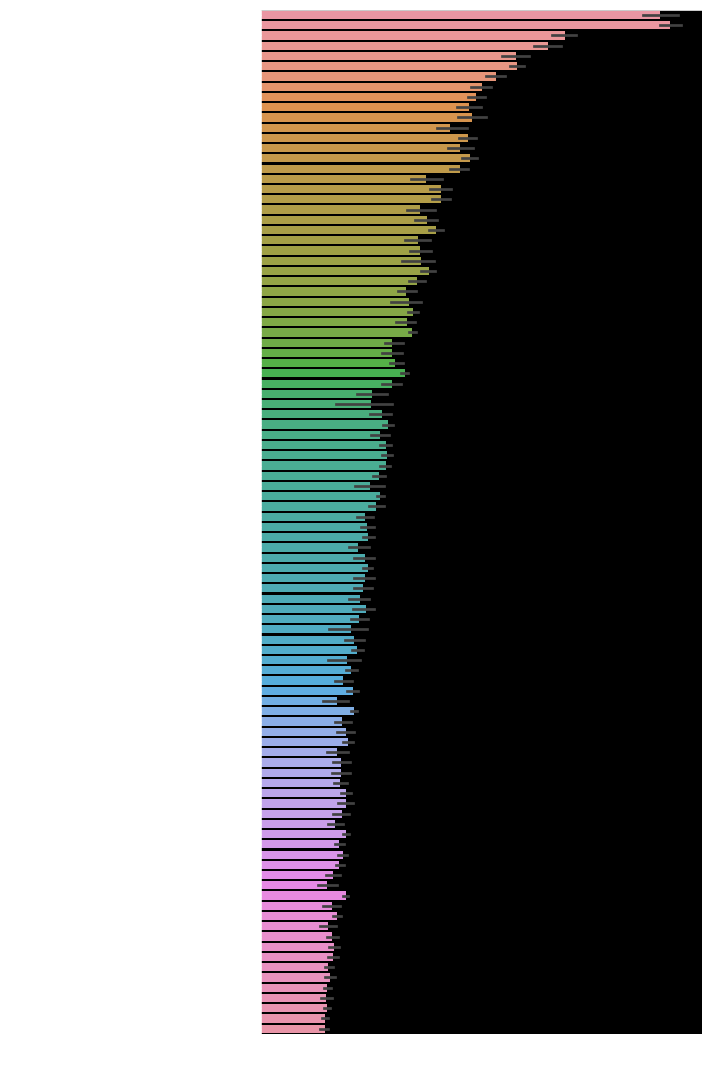

In [13]:
############ VARIABLE IMPORTANCE

# load importance    
top_feats = 100
cols = importances[['Feature', 'Importance']].groupby('Feature').mean().sort_values(by = 'Importance', ascending = False)[0:top_feats].index
importance = importances.loc[importances.Feature.isin(cols)]
    
# plot variable importance
plt.figure(figsize = (10, 15))
sns.barplot(x = 'Importance', y = 'Feature', data = importance.sort_values(by = 'Importance', ascending = False))
plt.tight_layout()
plt.savefig('../var_importance.pdf')

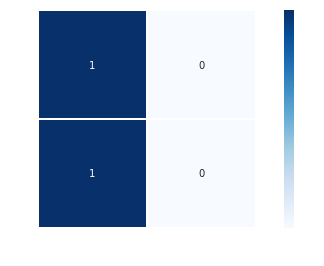

In [14]:
########## CONFUSION MATRIX

# construct confusion matrx
cm = confusion_matrix(y, np.round(preds_oof))
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

# plot matrix
fig, ax = plt.subplots(figsize = (10, 4))
sns.heatmap(cm, cmap = 'Blues', annot = True, lw = 0.5)
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth')
ax.set_aspect('equal')

# SUBMISSION

In [15]:
# file name
model = 'lgb_v9'
perf  = str(round(cv_perf, 6))[2:7]
name  = model + '_' + perf
name

'lgb_v9_88420'

In [16]:
# export OOF preds
oof = pd.DataFrame({'TransactionID': train['TransactionID'], 'isFraud': preds_oof})
oof.to_csv('../oof_preds/' + str(name) + '.csv', index = False)
oof.head()

,TransactionID,isFraud
0,2987000,0.044988
1,2987001,0.031268
2,2987002,0.027202
3,2987003,0.032589
4,2987004,0.030179


In [17]:
# export submission
sub = pd.DataFrame({'TransactionID': test['TransactionID'], 'isFraud': preds_test})
sub.to_csv('../submissions/' + str(name) + '.csv', index = False)
sub.head()

,TransactionID,isFraud
590540,3663549,0.025037
590541,3663550,0.026700
590542,3663551,0.026871
590543,3663552,0.023913
590544,3663553,0.023882


In [18]:
# check rank correlation with the best submission
from scipy.stats import spearmanr
sub  = sub.sort_values('TransactionID')
best = pd.read_csv("../submissions/BlendSolution.csv")
best = best.sort_values('TransactionID')
spearmanr(sub.isFraud, best.isFraud)

SpearmanrResult(correlation=0.5880593017030654, pvalue=0.0)

# PSEUDO-LABELING

In [45]:
############ DATA AUGMENTATION

# find confident predictions
percent  = 0.01
sure_idx = np.where((preds_test > np.quantile(preds_test, 1 - percent)) | (preds_test < np.quantile(preds_test, percent)))

# extract X and Y
y_sure = pd.Series(np.round(preds_test[sure_idx]))
x_sure = test.iloc[sure_idx].reset_index(drop = True)

# augment the data
print(train[features].shape, y.shape)
train = pd.concat([train, x_sure], axis = 0)
y     = pd.concat([y,     y_sure], axis = 0)
print(train[features].shape, y.shape)

(1058386, 504) (598602,)
(1066448, 504) (606664,)


In [ ]:
############ CROSS-VALIDATION LOOP
cv_start  = time.time()
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train, y, groups = train['DT_M'])):
    
    # data partitioning
    trn_x, trn_y = train[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train[features].iloc[val_idx], y.iloc[val_idx]
    test_x       = test[features]
    
    # label encoding
    trn_x, val_x, test_x = label_encoding(trn_x, val_x, test_x)

    # print data dimensions
    print('Data shape:', trn_x.shape, val_x.shape)
        
    # train lightGBM
    clf = lgb.LGBMClassifier(**lgb_params) 
    clf = clf.fit(trn_x, trn_y, 
                  eval_set              = [(trn_x, trn_y), (val_x, val_y)], 
                  eval_metric           = 'auc', 
                  early_stopping_rounds = stopping,
                  verbose               = verbose)
    clfs.append(clf)
    
    # find the best iteration
    best_iter = clf.best_iteration_

    # save predictions
    preds_oof[val_idx] = clf.predict_proba(val_x,  num_iteration = best_iter)[:, 1]
    preds_test        += clf.predict_proba(test_x, num_iteration = best_iter)[:, 1] / folds.n_splits 
    
    # print performance
    print('--------------------------------')
    print('FOLD%2d: AUC = %.6f' % (n_fold + 1, roc_auc_score(y[val_idx], preds_oof[val_idx])))
    print('--------------------------------')
    print('')
        
    # clear memory
    del trn_x, trn_y, val_x, val_y
    gc.collect()
    
    
# print overall performance    
cv_perf = roc_auc_score(y, preds_oof)
print('--------------------------------')
print('- OOF AUC = %.6f' % cv_perf)
print('- CV TIME = {:.2f} min'.format((time.time() - cv_start) / 60))
print('--------------------------------')

In [ ]:
# file name
model = 'lgb_v9ssl'
perf  = str(round(cv_perf, 6))[2:7]
name  = model + '_' + perf
name

In [ ]:
# export OOF preds
oof = pd.DataFrame({'TransactionID': train['TransactionID'], 'isFraud': preds_oof})
oof.to_csv('../oof_preds/' + str(name) + '.csv', index = False)
oof.head()

In [ ]:
# export submission
sub = pd.DataFrame({'TransactionID': test['TransactionID'], 'isFraud': preds_test})
sub.to_csv('../submissions/' + str(name) + '.csv', index = False)
sub.head()

In [ ]:
# check rank correlation with the best submission
from scipy.stats import spearmanr
sub  = sub.sort_values('TransactionID')
best = pd.read_csv("../submissions/BlendSolution.csv")
best = best.sort_values('TransactionID')
spearmanr(sub.isFraud, best.isFraud)